In [1]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# DReddit. Run from it. Destiny still arrives...
##### (D)Reddit data. Run (from) it in python. Destiny to cluster still arrives. -Thanos

### Executive Summary

Reddit is a site that embodies the concept of internet, similarly promoting diversity of posts and ideas. In order to identify or classify this diversity, NLP was performed to the post titles which were then clustered using K-Means. Thirteen clusters were identified from the internal validation criteria. From the clusters found, there were similar clusters that can be merged and one cluster that can be divided. Nonetheless, certain topics like the political parties, cars and food, among others, were properly identified and clustered.

In [ ]:
# Preliminaries
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score, 
                             calinski_harabaz_score, silhouette_score)
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import re
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('universal_tagset')


### Introduction

>Reddit, the frontpage of internet, gives you the best of the internet in one place.

The concept of the internet as the medium of people for sharing of ideas, feelings, beliefs, jokes, or anything under the sun is captured by the Reddit site. However, due to the diversity of people, users only want to look at specific contents. As such, the posts of the users are grouped into subreddits. These subreddits are assumed to contain topics which are similar to each other, under the title of the subreddit. The problem then is: using some sample data, NLP, and clustering, is it possible to identify the subreddits from the posts?

### Data Description

The source of the data is presumably Reddit, but without knowledge on which subreddits each post came from. For each post, two kinds of information are provided: the `author` and the `title`. The `author` is a categorical variable which identifies the user that posted the reddit post. The `title` column is a text data containing information on what type of post it is. Sample data is shown below:

In [3]:
df = pd.read_csv("reddit-dmw-sample.txt", delimiter='\t', index_col=0)
df.head()

,author,title
0,PrimotechInc,7 Interesting Hidden Features of apple ios9
1,xvagabondx,Need an advice on gaming laptop
2,nkindustries,Semi automatic ROPP Capping machine / ROPP Cap...
3,Philo1927,Microsoft Plumbs Ocean’s Depths to Test Underw...
4,tuyetnt171,OPPO F1 chính hãng - Fptshop.com.vn


### Data Processing


We want to categorize each post based on their topics. For this purpose, we do not need words that do not give context, i.e. stopwords. Aside from the stopwords from nltk, `amp` is also included which occurred due to the ampersand (&).

Duplicate posts, in the feature space, will be points at exactly the same location. This will affect the internal validations later as the same post will have twice the effect on the validations in spite of it being the same post.

The sample data after cleaning:

In [4]:
stop_words = stopwords.words('english') + ['amp']
df['title_cleaned'] = df.title.apply(lambda x: ' '.join(
    [w.lower() for w in re.findall('\w+', x) if w not in stop_words]))
df.drop_duplicates('title', inplace=False)
df.head()

,author,title,title_cleaned
0,PrimotechInc,7 Interesting Hidden Features of apple ios9,7 interesting hidden features apple ios9
1,xvagabondx,Need an advice on gaming laptop,need advice gaming laptop
2,nkindustries,Semi automatic ROPP Capping machine / ROPP Cap...,semi automatic ropp capping machine ropp cap s...
3,Philo1927,Microsoft Plumbs Ocean’s Depths to Test Underw...,microsoft plumbs ocean depths test underwater ...
4,tuyetnt171,OPPO F1 chính hãng - Fptshop.com.vn,oppo f1 chính hãng fptshop com vn


In language, a word can take different forms, e.g. plural vs singular, past vs present tenses. This makes analysis of texts more difficult since the tokens used in identifying a word is very precise that it requires an exact match in order to categorize two words as the same, i.e. words like `words` vs `word` would be treated as different words. In order to minimize the differences due to the different form of words, **lemmatization** can be used to return the words to their base form [2]. However, this causes errors due to homographs (same spelling). Moreover, there are some cases where the lemmatization will fail due to the difficulty of the process. Nonetheless, it is still used in this analysis since the effect of NOT classifying `words` and `word` as the same word has a significant effect, especially since the posts only have a few words to compare with.

Note, however, that there will be slight changes in the words after recovering them due to the lemmatization. For example, `United States` will become `unite state`.

In [5]:
lemmatizer = WordNetLemmatizer()
pos_dict = {'NOUN': 'n', 'ADJ': 'a', 'ADJ': 'r', 'VERB': 'v'}

df['title_cleaned'] = df.title_cleaned.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word, pos_dict[pos]) if pos_dict.get(pos) else
     word for word, pos in nltk.pos_tag(nltk.word_tokenize(x),
                                        tagset='universal')]))
# Lemmatize based on part of speech to minimize error due to homographs

# Clean it again
df['title_cleaned'] = df.title_cleaned.apply(lambda x: ' '.join(
    [w for w in re.findall('\w+', x) if w not in stop_words]))
df.head()

,author,title,title_cleaned
0,PrimotechInc,7 Interesting Hidden Features of apple ios9,7 interesting hidden feature apple ios9
1,xvagabondx,Need an advice on gaming laptop,need advice game laptop
2,nkindustries,Semi automatic ROPP Capping machine / ROPP Cap...,semi automatic ropp cap machine ropp cap seal ...
3,Philo1927,Microsoft Plumbs Ocean’s Depths to Test Underw...,microsoft plumb ocean depths test underwater d...
4,tuyetnt171,OPPO F1 chính hãng - Fptshop.com.vn,oppo f1 chính hãng fptshop com vn


Posts that are purely non-English alphabet will be removed because:
1. They will add features to our vector which will only increase the already long computational time needed for clustering and feature reduction.
2. We are unable to translate them into English, meaning even if two posts, one English and one Chinese, have the same content, it is unlikely for them to be clustered together.
3. Interpreting the results of the other languages is unnecessarily difficult since (a) there are only a few of them and (b) the author lacks any knowledge of foreign languages.

In [6]:
df = df[pd.notnull(df.title_cleaned.str.extract('([a-z])'))[0]]

### Exploratory Data Analysis

#### n-gram frequencies

We first look at our data, particularly the common n-grams (from 1 to 3):

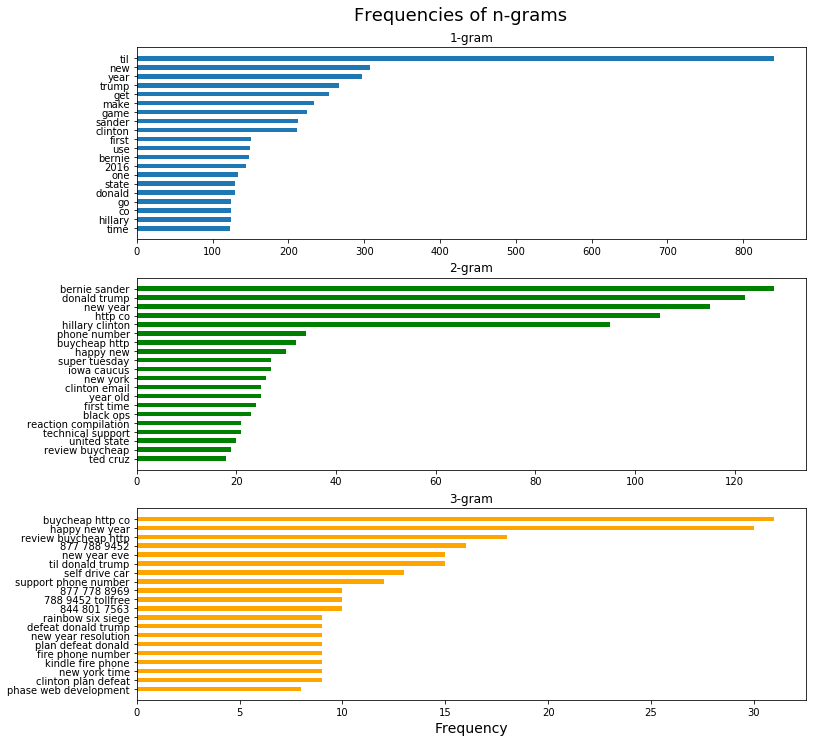

In [7]:
fig, ax = plt.subplots(3, figsize=(12,4*3))
fig.suptitle('Frequencies of n-grams', size=18, y=0.9275)
top_n = 20

colors = [None, 'green', 'orange']
for n in range(1, 4):
    words = re.findall(r'(?=\b(\w{2,}'+' \w{2,}'*(n-1) + '))',
                       ' '.join(list(df['title_cleaned'])))

    word, count_word = np.unique(words, return_counts=1)
    ax[n-1].barh(word[np.argsort(count_word)[:-top_n-1:-1]][::-1], 
                 np.sort(count_word)[:-top_n-1:-1][::-1], height = 0.5,
                 color=colors[n-1]);
    ax[n-1].set_title(f"{n}-gram", size=12)
ax[-1].set_xlabel('Frequency', size=14);


Looking at the common n-grams, aside from the unigrams, there are bigrams that are necessary to be treated as bigrams for them to make more context, e.g. names like `donald trump` or events like `new year`. On the other hand, only few 3-grams are needed (like `happy new year`) for context. As such in choosing features, the analysis is limited to 1 and 2-grams. While including higher n-grams could lead to more features for clustering, it also means longer runtime and higher requirements for the computation.

#### Post length in words

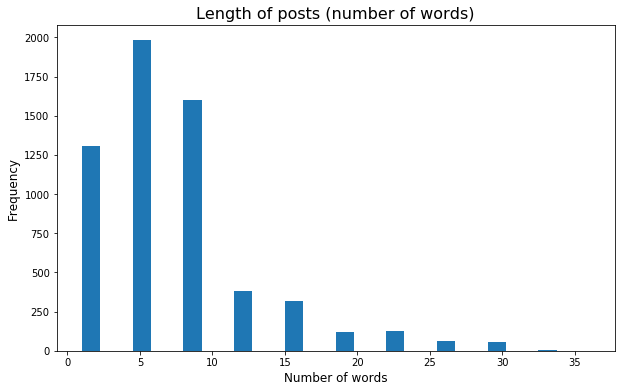

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
df['title_cleaned'].apply(lambda x: len(x.split())).hist(ax=ax, width=1.25)
ax.set_xlabel("Number of words", size=12)
ax.set_ylabel("Frequency", size=12)
ax.set_title("Length of posts (number of words)", size=16)
ax.grid('off')

Most posts have around 5 to 10 words with the longest post at around 35 words. From this, it can be seen that the features each post has is minimal so, in retrospect, lemmatization is necessary for posts to have more similar features. 

Let's look at the documents where there are words that are non-unique (3 or more occurrence of a word in a single document)

In [9]:
def high_occurrence(doc, n_words=3):
    """Generate the word with highest frequency in a post, the frequency, and
    the post. Return those with a word that has a higher frequency than
    n_words
    """
    word = max(set(doc.split()), key=doc.split().count)
    count_max = doc.split().count(word)
    if count_max >= n_words:
        return (word, count_max, doc)


df_freqwords = df['title_cleaned'].apply(lambda x:
                                         high_occurrence(x)).dropna()

print(f"There are {len(df_freqwords)} posts that have words with high "
      "frequency.")
print("Some sample words, their frequencies in the post and the post itself:")
df_freqwords[:20].apply(pd.Series).rename(
    {0: 'word', 1: 'count', 2: 'post'}, axis=1).sort_values('count', 
                                                            ascending=False)

There are 125 posts that have words with high frequency.
Some sample words, their frequencies in the post and the post itself:


,word,count,post
320,kovan,4,star kovan star kovan brand new mixed developm...
41,politics,3,thanks corporate insect ruin reddit r politics...
450,use,3,trump use hairspray hairspray go affect ozone ...
855,potato,3,doubt make sort potato dish winter like favori...
799,award,3,nsfw til shasha grey youngest recepient avn fe...
618,orion,3,til sword orion constellation contain orion ne...
566,cell,3,til human brain cell infinite neither 100 bill...
554,http,3,microsoft want data centre ocean http co s8wap...
550,table,3,til ww2 cambridge professor accidentally drop ...
540,http,3,microsoft surface pro 4 big high tech surprise...


Looking at the words that are repeated more than 3 times in a single post, there are cases where the fact that it was used many times meant that it was a very important word in giving context to the post. However, there are also cases where it didn't (like `1` in post 295, `co` in post 540 and 554). In giving importance to words that occurred more than once in a post, the effect is not necessarily linear (word occurring twice does not mean that its importance doubles).

#### Author frequencies

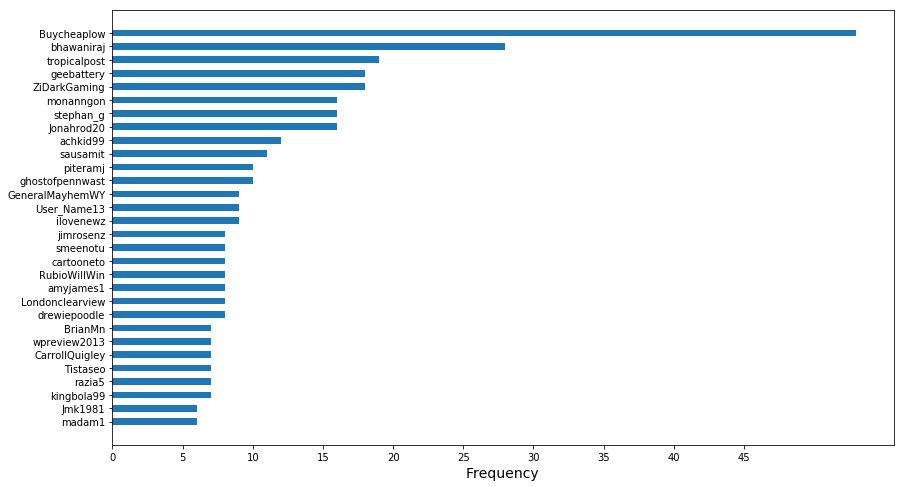

In [10]:
author, count_author = np.unique(df['author'], return_counts=1)
fig, ax = plt.subplots(figsize=(14, 8))
top_n = 30
ax.barh(author[np.argsort(count_author)[-2:-top_n-2:-1]][::-1],
        np.sort(count_author)[-2:-top_n-2:-1][::-1], height=0.5)
ax.set_xticks(range(0, 50, 5))
ax.set_xlabel("Frequency", size=14);
# print(dict(zip(word[np.argsort(count)[::-1]][:50], np.sort(count)[::-1][:50])))

# We will use the authors later for target clustering

Looking at the top 2 authors in the file (since they are the ones with significantly higher posts), Buycheaplow posts different products to sell while bhawaniraj only has short posts of names of softwares. We expect bhawaniraj's posts to have difficulty clustering since the posts will only have one to three features that are completely different from each other. On the other hand, Buycheaplow uses a certain format that is easily distinguishable so it is possible for a cluster of Buycheaplow to form.

#### Some common words

Observing the number of posts that has `TIL` and `NSFW`:

In [11]:
df['TIL'] = pd.notnull(df['title'].str.extract("(TIL)"))
df['NSFW'] = pd.notnull(df['title'].str.extract("(NSFW)"))
100*df[['TIL', 'NSFW']].sum() / len(df)

TIL     13.995637
NSFW     0.134251
dtype: float64

NSFW posts are scarce while the TIL posts are frequent in this dataset. It seems that NSFW cannot be used for the analysis of this dataset. On the other hand, the word TIL is too frequent which could affect our analysis especially since TIL is not native to a single subreddit which means it might interfere with the clustering.

### Vectorizing the posts

With raw text data, measuring the differences between all the texts and identfying which texts are similar is difficult since texts do not have a concept of distance between each other. By representing a text as a vector with its features/components as the words inside the text, it becomes easy (logically, not computationally) to quantify the differences of the texts. To do this, two common methods are the TF-IDF vectorizer and the count vectorizer (bag-of-words).

TF-IDF measures the relevance of a word by getting its frequency inside the document (term frequency, TF) with a weight that decreases the relevance as the word becomes more common among different documents (document frequency, DF). On the other hand, the count vectorizer only deals with TF, although not normalized.

In this case, posts with similar contents are expected to be grouped together. As for the nature of the similarity, it is still unknown at this point. In choosing which method to use for vectorizing the text, there are a few considerations. First, before vectorizing, we have already removed stopwords. Second, the texts being analyzed are the titles. Considering both, there is an expectation that all remaining words are relevant. By using IDF, we are reducing the relevance of the words that occur across different documents which is not what we need in this case. Therefore, count vectorizer is preferred to be used. However, it counts frequencies without weights (that is, two occurrences of the words imply double the relevance). Instead, TF-IDF will be used but without IDF.

The results of the EDA is considered for the parameters of TfidfVectorizer:
- `token_pattern='\w{2,}'`: to further filter out single letter words that are not removed during the cleaning, a token pattern of `\w{2,}` is used to classify word features
- `ngram_range=(1,2)`: looking at the word frequencies in the posts, a range of `(1, 2)` is used since there are names (Donald Trump) and other two-word phrases (video games) that is necessary for the analysis
- `stop_words=stop_words`: to further clean the data (in case the stopwords of nltk is different from sklearn's).
- `min_df=0.001`: since the documents are too short (longest title at around 35 words), the threshold for the number of documents a word should occur in must not be too high. In this case, the threshold is set at `0.1%` (~6 documents) in order to filter out words that are too unique.
- `use_idf=False`: IDF dampens the effect of common words across different documents which is not needed for this analysis
- `sublinear_tf=True`: effect of higher frequency of a word in a post must be diminished since doubling the number of words does not translate to double the relevance of the word

In [12]:
tfidf_vectorizer = TfidfVectorizer(token_pattern='\w{2,}', 
                                   ngram_range=(1, 2),
                                   stop_words=stop_words,
                                   min_df=0.001, 
                                   use_idf=False,
                                   sublinear_tf=True)

bow_reddit = tfidf_vectorizer.fit_transform(df['title_cleaned'])
nonzeros = bow_reddit.sum(axis=1).nonzero()[0]
bow_reddit = bow_reddit[nonzeros]

In [13]:
print('Number of features: ', len(tfidf_vectorizer.vocabulary_))

Number of features:  1839


In [14]:
print('Number of stop words: ', len(tfidf_vectorizer.stop_words_))

Number of stop words:  44514


### Dimensionality reduction

The next step would be to check the number of features to reduce the vector to while still capturing the variations of the data.

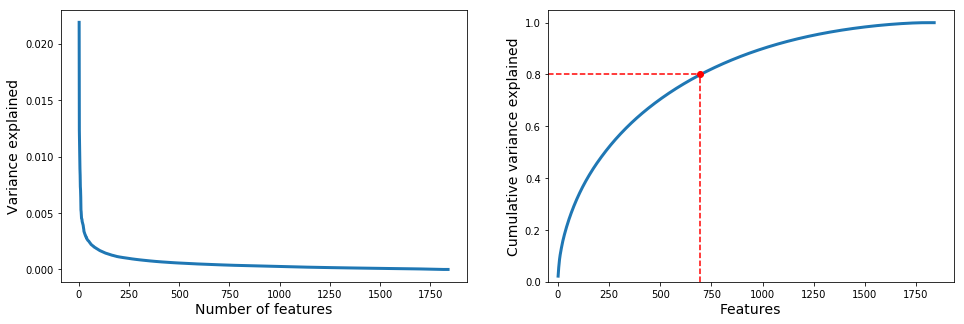

In [15]:
V = np.cov(bow_reddit.toarray(), rowvar=False)

lambdas, w = np.linalg.eig(V)
indices = np.argsort(lambdas)[::-1]
lambdas = lambdas[indices]
w = w[:, indices]
var_explained = lambdas / lambdas.sum()
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].plot(np.arange(1, len(var_explained)+1), var_explained, lw=3)
ax[0].set_xlabel('Number of features', size=14)
ax[0].set_ylabel('Variance explained', size=14);

cum_var_explained = var_explained.cumsum()
# fig, ax = plt.subplots(figsize=(12,6))
n_PC = np.searchsorted(cum_var_explained, 0.8)
ax[1].plot(np.arange(1, len(cum_var_explained)+1), 
           cum_var_explained, '-', zorder=1, lw=3)
ax[1].set_ylim(ymin=0)
ax[1].plot([-50, n_PC], [0.8, 0.8], 'r--')
ax[1].plot([n_PC, n_PC], [0, 0.8], 'r--')
ax[1].scatter(n_PC, 0.8, c='r', zorder=2)
ax[1].set_xlim(-50,)
ax[1].set_xlabel('Features', size=14)
ax[1].set_ylabel('Cumulative variance explained', size=14);

To get a cumulative variance of at least 0.8, ~700 is the minimum number of features. Note that the choice of 0.8 is a matter of tradeoffs wherein the accuracy is traded for the complexity, i.e. increasing the threshold cumulative variance from 0.8 would require a larger increase in feature than when the cumulative variance is at 0.5 but it has more features or information. 

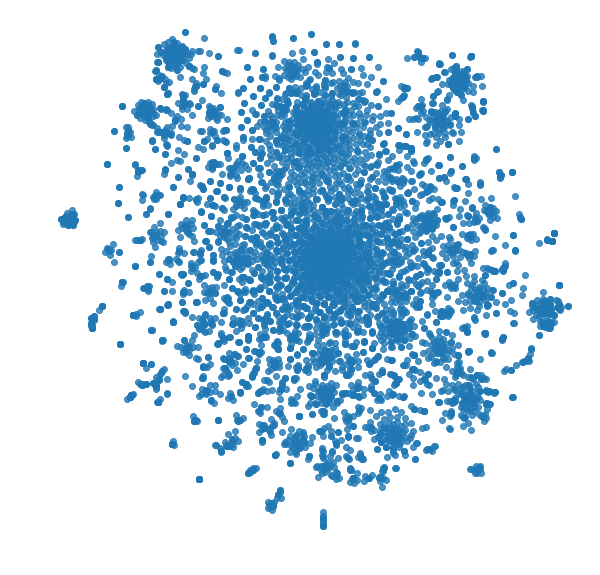

In [16]:
X_reddit = TruncatedSVD(n_components=n_PC).fit_transform(bow_reddit)
X_reddit_new = TSNE(random_state=1337, perplexity=100).fit_transform(X_reddit)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_reddit_new[:,0], X_reddit_new[:,1], alpha=0.8);
#since TSNE doesn't preserve distances anyway, the axis labels doesn't matter
ax.set_axis_off(); 

From the figure above, there are a few noticeable clusters but they aren't clearly separated which could be attributed to the TSNE and the attempt to visualize 706 features in 2 dimensions. We leave it to the clustering algorithms to group the posts what our eyes and minds couldn't.

### Clustering

For this analysis, `K-Means` clustering will be used. Looking at the clusters in the TSNE representation, there seems to be tens of clusters with two big clusters. In most of these, the clusters look spherical (circular since 2D) so K-Means is an appropriate methodology.

In clustering, there are external and internal validations. Since we have no information on the actual clustering, only the internal validations can be performed. We test the K-Means clusters for 2 to 20 in an attempt to capture most of the clusters shown in the TSNE.

But first, a code dump of previous exercises for the validation criteria:

In [17]:
def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample

    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """
    # YOUR CODE HERE

    p_list = []
    q_list = []

    np.random.seed(11)
    z = np.random.choice(X.shape[0], size=(r, 2))
    for i, j in z:
        if i == j:
            continue
        elif y[i] == y[j]:
            p_list.append(dist(X[i], X[j]))
        else:
            q_list.append(dist(X[i], X[j]))

    return (np.average(p_list) / np.average(q_list))


def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    """Calculate the validation criterion for different numbers of clusters
    given the clusterer and an optional actual classifications.
    """
    # YOUR CODE HERE
    ys = []
    inertias = []
    chs = []
    iidrs = []
    scs = []
    ps = []
    amis = []
    ars = []

    for k in range(k_start, k_stop+1):
        np.random.seed(11)
        kmeans_X = KMeans(n_clusters=k, random_state=clusterer.random_state)
        y_predict_X = kmeans_X.fit_predict(X)
        ys.append(y_predict_X)
        inertias.append(kmeans_X.inertia_)
        chs.append(calinski_harabaz_score(X, y_predict_X))
        iidrs.append(intra_to_inter(X, y_predict_X, euclidean, 50))
        scs.append(silhouette_score(X,  y_predict_X))

        if actual is not None:
            ps.append(purity(actual, y_predict_X))
            amis.append(adjusted_mutual_info_score(actual, y_predict_X,
                                                   average_method='max'))
            ars.append(adjusted_rand_score(actual, y_predict_X))

    valid = {}
    valid['ys'] = ys
    valid['inertias'] = inertias
    valid['chs'] = chs
    valid['iidrs'] = iidrs
    valid['scs'] = scs
    if actual is not None:
        valid['ps'] = ps
        valid['amis'] = amis
        valid['ars'] = ars
    return valid
    #raise NotImplementedError()


def plot_internal(inertias, chs, iidrs, scs):
    """Plot internal validation values"""
    fig, ax = plt.subplots(4, figsize=(12, 12), sharex=True)
    ks = np.arange(2, len(inertias)+2)
    ax[0].plot(ks, inertias, 'r-o', label='SSE', lw=3)
    ax[1].plot(ks, chs, '-go', label='CH', lw=3)
    ax[0].set_ylabel('SSE', size=12)
    ax[1].set_ylabel('CH', size=12)
    ax[2].plot(ks, iidrs, '-ro', label='Inter-intra', lw=3)
    ax[3].plot(ks, scs, '-go', label='Silhouette coefficient', lw=3)
    ax[2].set_ylabel('Inter-intra', size=12)
    ax[3].set_ylabel('Silhouette coefficient', size=12)
    fig.text(0.5, 0.075, '$k$', size=14)
    return ax

Let us run through the internal validations and their preferred values, keeping in mind that the characteristics of good clustering are: **compact**, **separated**, **balanced**, and **parsimonious**.

A brief description and the preferred values of the internal validation:
- <font color='red'>SSE $\downarrow$</font>: sum of squared distances to centroids describes how close the points in the cluster are to their representative points, i.e. how compact the clusters are. This value is minimized with to obtain **compact** clusters.
- <font color='green'>CH $\uparrow$</font>: Calinski-Harabasz index is the ratio of the how far away the clusters are to the center of all points (separated) versus the how far the cluster points are to the cluster center (compact). This is maximized for **separated** (high numerator) and **compact** (low denominator) clusters.
- <font color='red'>Intra/Inter $\downarrow$</font>: The ratio of intracluster (inside cluster) and intercluster (outside cluster) distances. The characteristics of a good cluster that it affects is similar to CH but reversed (although the algorithm itself is different). So, this is minimized for **separated** (low numerator/intra) and **compact** (high denominator/inter). Note that there is random sampling involved in this algorithm so the number of points in a cluster affects the sampling so it affects **balanced** by making the values more susceptible to error (but we cannot tell how balanced the clusters are based on the values).
- <font color='green'>Silhouette coefficient $\uparrow$</font>: measures the ratio of the smallest intercluster distance and the average intracluster distance. In this case, the intercluster distance is "local" in the sense that the distance to the nearest cluster is taken instead of the average with all the other clusters. So high intercluster neighbor distance and low average intracluster is preferred for good clustering i.e. high values are preferred for **separated** (locally) and **compact**. With the normalization, the range of value is -1 to 1 so 1 is preferred.

In most cases, there will be tradeoffs, particularly in the **parsimonious** characteristic since validations like SSE and Silhouette coefficient will have a low and high value, respectively, as the number of clusters is increased. 

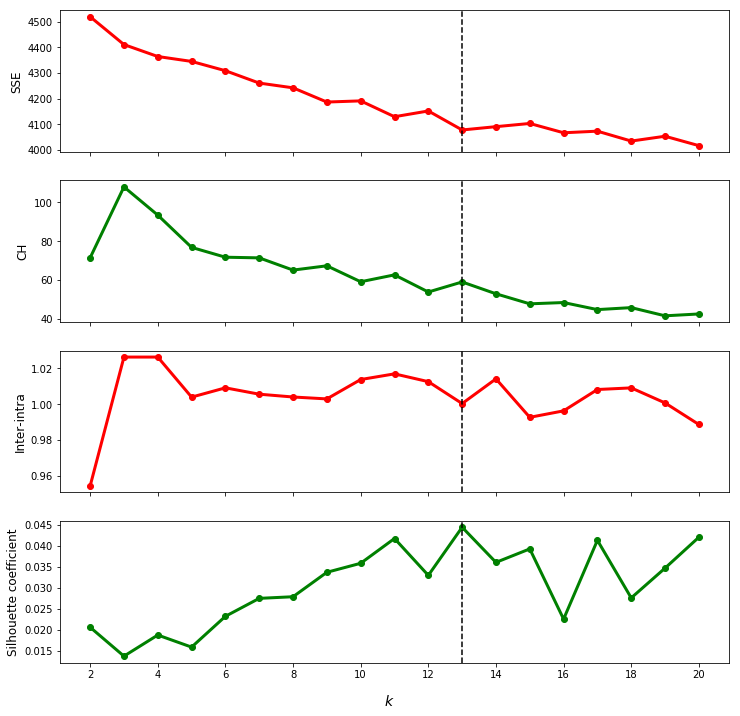

In [18]:
res_reddit = cluster_range(X_reddit, KMeans(random_state=1337), 2, 20)
                         
ax = plot_internal(res_reddit['inertias'], res_reddit['chs'],
                   res_reddit['iidrs'], res_reddit['scs']);
for a in ax:
    a.axvline(13, c='k', ls='--')
    
ax[-1].set_xticks(range(2, 21, 2));

Looking at the validation criteria, higher number of clusters yield a better Silhouette coefficient and SSE while the opposite is true for CH. Note that there is no precise way of checking the best number of clusters from this so it will depend on balancing the different validation criteria. Balancing all the validation criteria, 13 clusters is chosen.

In [19]:

k = 13
feats = tfidf_vectorizer.get_feature_names()
kmeans = KMeans(n_clusters=k, random_state=1334)
y_kmeans = kmeans.fit_predict(X_reddit)

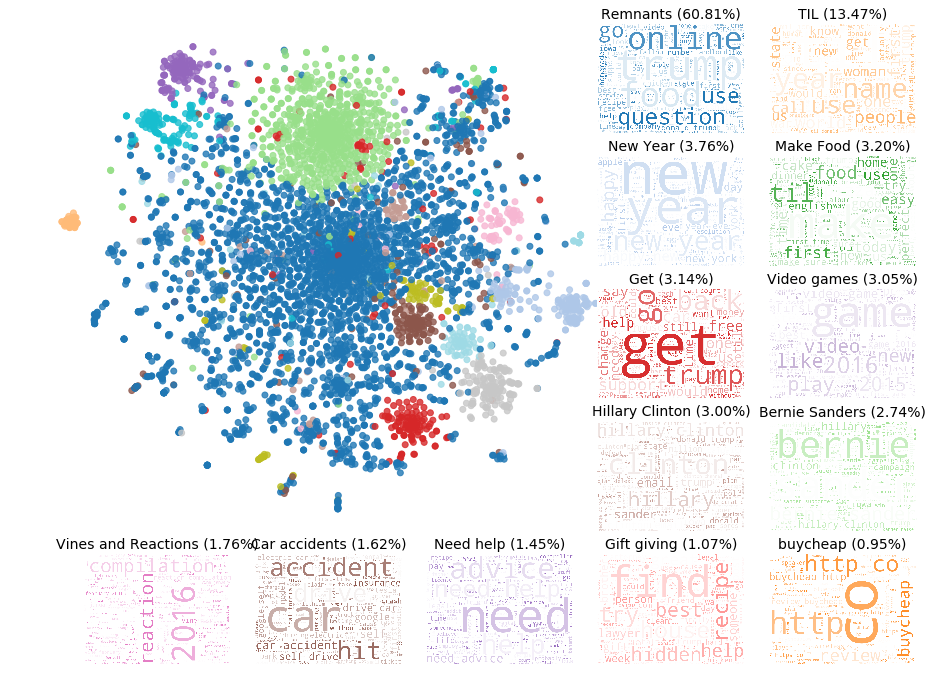

In [22]:
cmap = matplotlib.cm.get_cmap('tab20')
fig = plt.figure(figsize=(32, 24))

gs = fig.add_gridspec(10, 10, wspace=-0.3)

ax_main = fig.add_subplot(gs[:4, :3])
ax_main.scatter(X_reddit_new[:,0], X_reddit_new[:,1], alpha=0.8, c=y_kmeans,
                cmap=cmap);
#since TSNE doesn't preserve distances anyway, the axis labels doesn't matter
ax_main.set_axis_off(); 

y_counts = np.array(np.unique(y_kmeans, return_counts=1))
y_sorted = y_counts[:, np.argsort(y_counts[1, :])[::-1]]
gs_dict = {0:(0, 3), 1:(0, 4), 2:(1, 3), 3:(1, 4), 4:(2, 3), 5:(2, 4), 
           6:(3, 3), 7:(3, 4), 8:(4, 0), 9:(4, 1), 10:(4, 2), 11:(4, 3),
           12:(4, 4)}
name = ['Remnants', 'TIL', 'New Year', 'Make Food', 'Get', 'Video games',
        'Hillary Clinton', 'Bernie Sanders', 'Vines and Reactions',
        'Car accidents', 'Need help', 'Gift giving', 'buycheap']
for i in range(y_sorted.shape[1]):
    n = y_sorted[0, i]
    color = cmap(n)
    
    cmap_i = LinearSegmentedColormap.from_list('mycmap', ['white', color])

    cluster = bow_reddit[y_kmeans == n].sum(axis=0)
    nonzero = cluster.A1 > 0
    word_cld = dict(zip(np.array(feats)[nonzero], cluster.A1[nonzero]))
    wordcloud = WordCloud(width=800, height=600,
                          background_color='white',
                          collocations=False,
                          colormap = cmap_i).generate_from_frequencies(
        word_cld)
    ax = fig.add_subplot(gs[gs_dict[i]])
    ax.set_title(
        f"{name[i]} ({100*y_sorted[1, i]/y_sorted.sum(axis=1)[1]:.2f}%)", 
        size=14)
    ax.imshow(wordcloud)
    ax.set_axis_off()

In [ ]:
import operator
def check_top_20(n):
    cluster = bow_reddit[y_kmeans == n].sum(axis=0)
    nonzero = cluster.A1 > 0
    word_cld = dict(zip(np.array(feats)[nonzero], cluster.A1[nonzero]))
    return sorted(word_cld.items(), key=operator.itemgetter(1), 
                  reverse=True)[:20]

check_top_20(0)

Thirteen clusters were identified from the sample reddit posts. A large part of the posts were clustered into one big cluster. Looking at the words in that cluster in the largest cluster, which we name `Remnants` (blue), the words are very diverse in that it is difficult to identify what subreddit it is. In the TSNE representation, `Remnants` cluster is a very large cluster that "swallows" some of the other clusters. We can consider this as the remnants of the clustering as it can be further broken down into subclusters. 
Furthermore, there are clusters that look like two clusters classified together, e.g. `New Year` cluster (light blue) since there are two distinct clusters in the TSNE. However, the opposite is also true where two clusters can be merged into one bigger cluster, e.g. `Bernie Sanders` and `Hillary Clinton` can be merged to `Democratic` cluster.

While we cannot actually compare and confirm whether the identified clusters are actual subreddits, the clustering algorithm was still successful in identifying clusters with topics that are actually related. Exceptions to that, however, are clusters that are formed due to one word, i.e. `TIL` and `Get`. The `TIL` cluster can possibly be an appropriate cluster since there is a subreddit of TIL. `Get` may be a negative consequence of the choice of vectorizer (TF) since the effect of multiple occurrence of the word get across multiple documents were not taken into account on the vectorization.

### Conclusions and Recommendations

Using NLP for pre-processing and K-Means for clustering, thirteen clusters were identified from the given sample reddit posts. In these clusters, there are similar ones like `Bernie Sanders` (light green) and `Hillary Clinton` (light brown) as an artifact of choosing too many clusters. But, there are also clusters that could be further divided into subclusters like `New Year`, though we cannot conclude what these two subclusters are. Lastly, some clusters formed due to the existence of a single word as an artifact of the choice of vectorizer (TF) like `Get` and `TIL`.

One observation on the randomness of the clustering is that it produces different results, particularly on the clusters with low number of posts. This can be attributed to the low post numbers, making the cluster susceptible to change and non-robust.

Nonetheless, we were still able to demonstrate clustering of posts that are related to each other, albeit imperfectly. Several suggestions can be made to improve this result. First, identifying whether "get", among other words, is a stopword or not depends on the person's choice of whether it provides context to the post or not. Second, addition or subtraction of number of cluster can be done which also depends on the desired granularity of the clusters. Finally, other clustering algorithms can be tested whether the clustering would be better or not.

### References
[1] Natural Language Toolkit. https://www.nltk.org/ <br/>
[2] Sublinear tf scaling. 2009 Cambridge University Press. https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html <br/>
[3] Anthony Brian Dy and Marlon Teodosio, *Subtopics in News Articles about Artificial Intelligence in the Last 30 Days*, 2019, DMW Project <br/>
[4] Tristan Joshua Alba and Jon Colipapa, *Internet-based Sentiment Analysis for Trading*, 2019, DMW Project <br/>
[5] Christian Alis and Eduardo David, DMW Exercises and Notebooks <br/>
[6] Reddit. https://www.reddit.com/

### Acknowledgements

I would like to acknowledge my LT-mates for the all the help in the project in the concepts, ideas and execution. Also to my other classmates for the flow of ideas in the classroom (in or out of class hours). To the profs for the guidelines on how to make a report and for the input during and after the lab session.